# A 03 IV: Evaluating the best model: XGBoost on MIT & PTB


## 1. Imports

In [35]:
import os 
from typing import Dict, Optional
import random 

# Evaluate the fitted MIT-trained XGBoost on the entire PTB dataset (train + val)
from src.utils.preprocessing import prepare_ptbdb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np


from src.utils import eval_model, evaluate_model
from src.visualization import plot_confusion_matrix
from src.utils.model_saver import create_model_saver

# external 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import loguniform, randint, uniform
import numpy as np
import re
import json

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Samplers

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from src.utils.preprocessing import (
    _normalize_sampling_method_name,
    _SAMPLING_REGISTRY
)


In [36]:
df_mitbih_train = pd.read_csv('data/original/mitbih_train.csv', header = None)
df_mitbih_test = pd.read_csv('data/original/mitbih_test.csv', header = None)

X_train = pd.read_csv('data/processed/mitbih/X_train.csv')
y_train = pd.read_csv('data/processed/mitbih/y_train.csv')
y_train = y_train['187']

X_train_sm = pd.read_csv('data/processed/mitbih/X_train_sm.csv')
y_train_sm = pd.read_csv('data/processed/mitbih/y_train_sm.csv')
y_train_sm = y_train_sm['187']

X_val = pd.read_csv('data/processed/mitbih/X_val.csv')
y_val = pd.read_csv('data/processed/mitbih/y_val.csv')

X_test = df_mitbih_test.drop(187, axis = 1)
y_test = df_mitbih_test[187]

print("MITBIH dataset - SMOTE")
print(f"\tTraining ORIG  size: {df_mitbih_train.shape}")
print(f"\tTraining SMOTE size: {X_train_sm.shape}, {y_train_sm.shape}")
print(f"\tTest size: {X_test.shape}, {y_test.shape}")
print(f"\tVal size: {X_val.shape}, {y_val.shape}")

MITBIH dataset - SMOTE
	Training ORIG  size: (87554, 188)
	Training SMOTE size: (289885, 187), (289885,)
	Test size: (21892, 187), (21892,)
	Val size: (17511, 187), (17511, 1)


## 2. Constants & Param Spaces

In [10]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

PARAMS = {
    "n_estimators": 500,
    "max_depth": 9,
    "learning_rate": 0.2,
    "subsample": 0.7,
    "colsample_bytree": 0.9,
    "reg_alpha": 0.2,
    "reg_lambda": 0.05,
    "min_child_weight": 5,
    "gamma": 0.0,
}

## 3. Run

In [11]:
model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="mlogloss",
    **PARAMS
)



In [12]:

# --- evaluation sets for learning curve ---
eval_set = [(X_train_sm, y_train_sm), (X_test, y_test)]

# --- fit model with eval_set to record progress ---
model.fit(
    X_train_sm, y_train_sm,
    eval_set=eval_set,
    verbose=False
)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [38]:
# --- classification report on validation set ---
y_pred = model.predict(X_test)

prec_macro_full, rec_macro_full, f1_macro_full, ptb_f1_per_class = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)

print(f"F1-Macro: {f1_macro_full:.4f}")
print(f"Precision-Macro: {prec_macro_full:.4f}")
print(f"Recall-Macro: {rec_macro_full:.4f}")


print("\nClassification Report (Validation Set):")
print(classification_report(y_test, y_pred, digits=4))

F1-Macro: 0.9096
Precision-Macro: 0.9223
Recall-Macro: 0.8981

Classification Report (Validation Set):
              precision    recall  f1-score   support

         0.0     0.9880    0.9935    0.9908     18118
         1.0     0.8727    0.7770    0.8221       556
         2.0     0.9627    0.9441    0.9533      1448
         3.0     0.8012    0.7963    0.7988       162
         4.0     0.9868    0.9795    0.9831      1608

    accuracy                         0.9823     21892
   macro avg     0.9223    0.8981    0.9096     21892
weighted avg     0.9819    0.9823    0.9820     21892



In [14]:
# --- extract evaluation history and plot ---
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

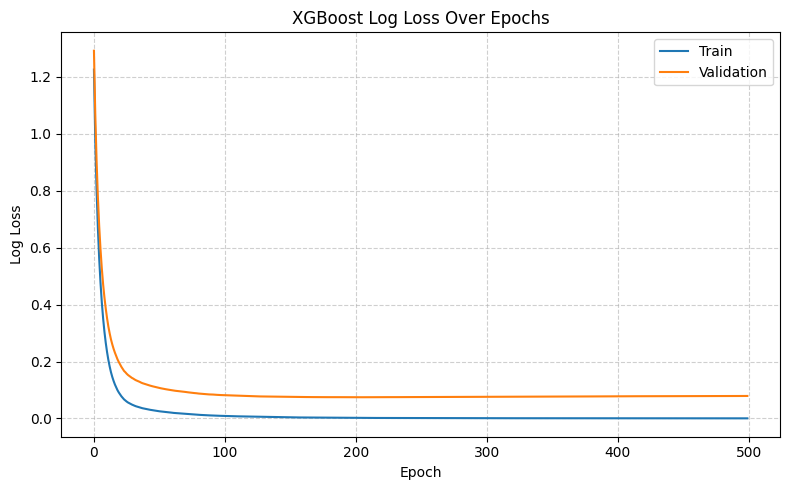

In [15]:
# --- extract evaluation history and plot ---
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(8, 5))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
plt.title('XGBoost Log Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

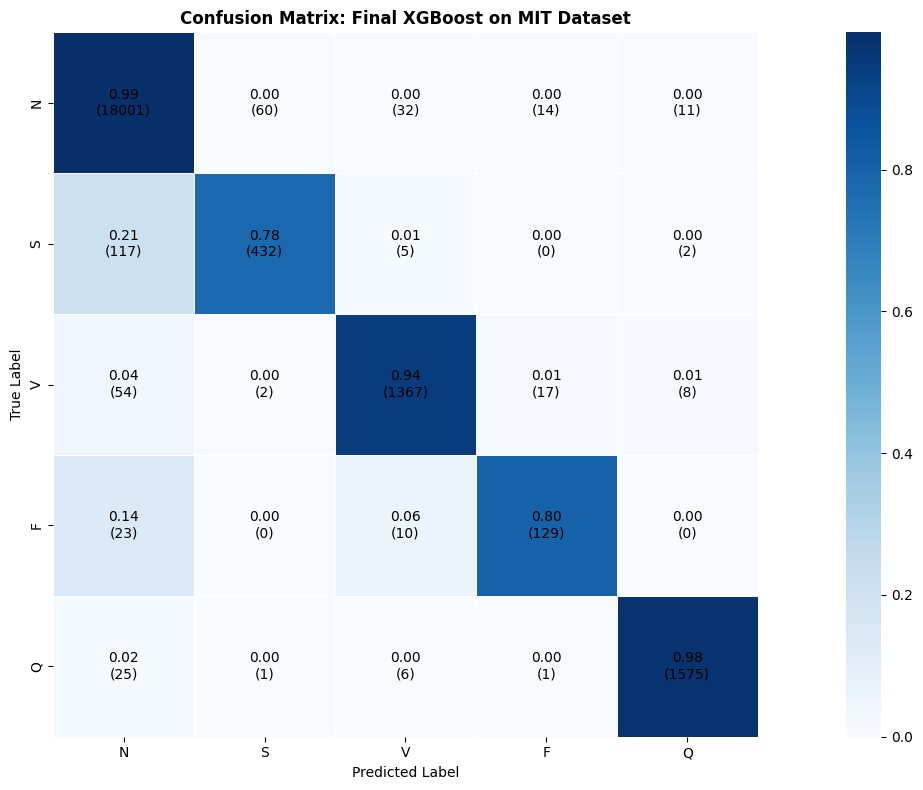

In [18]:
mit_labels = np.unique(np.concatenate([y_train_sm, y_test]))

mit_confusion = confusion_matrix(y_test, y_pred, labels=mit_labels)

class_names=["N", "S", "V", "F", "Q"]

plot_confusion_matrix(y_test, y_pred, normalize=True, 
                         class_names=class_names, figsize=(18, 8), 
                         cmap='Blues', title='Confusion Matrix: Final XGBoost on MIT Dataset')
plt.show()

# A4: Test on PTB data

- using same parameters and model as for MIT, but trained on PTB data

In [33]:
print("\n" + "="*80)
print("Evaluating MIT-trained 5-class XGBoost mapped to binary on full PTB (train+val)")
print("="*80)

# Load PTB split (both train and test)
# validation is left out to compare 
ptb_dir = "/home/christianm/Projects/Repos/heartbeat_classification/data/processed/ptb"
X_ptb_train = pd.read_csv(f"{ptb_dir}/X_ptb_train.csv").values
y_ptb_train = pd.read_csv(f"{ptb_dir}/y_ptb_train.csv").iloc[:, 0].values.astype(int)
X_ptb_train_sm = pd.read_csv(f"{ptb_dir}/X_ptb_train_sm.csv").values
y_ptb_train_sm = pd.read_csv(f"{ptb_dir}/y_ptb_train_sm.csv").iloc[:, 0].values.astype(int)
X_ptb_test = pd.read_csv(f"{ptb_dir}/X_ptb_test.csv").values
y_ptb_test = pd.read_csv(f"{ptb_dir}/y_ptb_test.csv").iloc[:, 0].values.astype(int)
X_ptb_val = pd.read_csv(f"{ptb_dir}/X_ptb_val.csv").values
y_ptb_val = pd.read_csv(f"{ptb_dir}/y_ptb_val.csv").iloc[:, 0].values.astype(int)
X_ptb_full = np.vstack([X_ptb_train, X_ptb_test, X_ptb_val])
y_ptb_full = np.concatenate([y_ptb_train, y_ptb_test, y_ptb_val])

print("PTB dataset")
print(f"\tTraining size: {X_ptb_train.shape}, {y_ptb_train.shape}")
print(f"\tTraining SMOTE size: {X_ptb_train_sm.shape}, {y_ptb_train_sm.shape}")
print(f"\tTest Size: {X_ptb_test.shape}, {y_ptb_test.shape}")
# print(f"\tVal Size: {X_ptb_val.shape}, {y_ptb_val.shape}")


Evaluating MIT-trained 5-class XGBoost mapped to binary on full PTB (train+val)



Evaluating MIT-trained 5-class XGBoost mapped to binary on full PTB (train+val)

PTB-DB Test Metrics:
Accuracy: 0.3524
F1-Macro: 0.3295
Precision-Macro: 0.5966
Recall-Macro: 0.5408

Per-class F1 scores:
  Class 0: 0.4533
  Class 1: 0.2057

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.2962    0.9654    0.4533       809
           1     0.8971    0.1162    0.2057      2100

    accuracy                         0.3524      2909
   macro avg     0.5966    0.5408    0.3295      2909
weighted avg     0.7300    0.3524    0.2746      2909


PTB Confusion Matrix (rows=true, cols=pred):
[[ 781   28]
 [1856  244]]


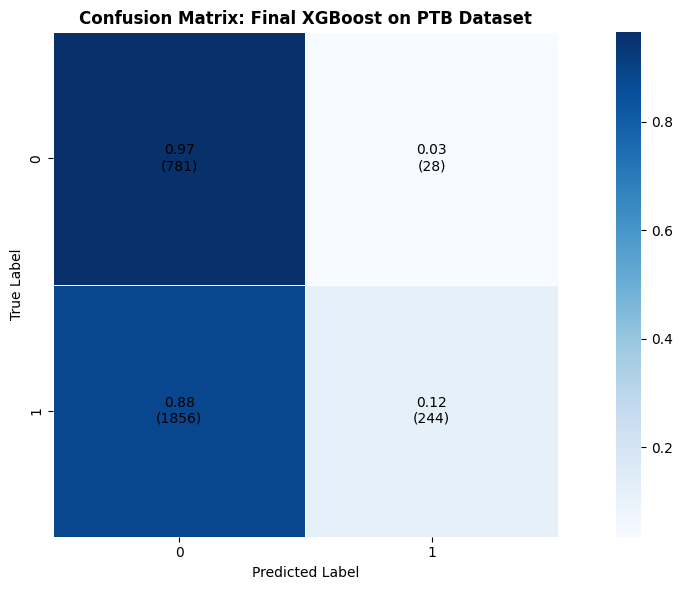

In [32]:


# Predict probabilities for 5 classes and map to binary (0 -> 0, 1/2/3/4 -> 1)
ptb_proba_5_full = model.predict_proba(X_ptb_test)
y_pred_ptb_5_full = np.argmax(ptb_proba_5_full, axis=1)

y_pred_ptb_bin_full = (y_pred_ptb_5_full != 0).astype(int)

# Metrics
acc_full = accuracy_score(y_ptb_test, y_pred_ptb_bin_full)
prec_macro_full, rec_macro_full, f1_macro_full, ptb_f1_per_class = precision_recall_fscore_support(
    y_ptb_test, y_pred_ptb_bin_full, average="macro", zero_division=0
)

# Per-class metrics
ptb_prec_per_class, ptb_rec_per_class, ptb_f1_per_class, _ = precision_recall_fscore_support(
    y_ptb_test, y_pred_ptb_bin_full, average=None, zero_division=0
)

ptb_confusion = confusion_matrix(y_ptb_test, y_pred_ptb_bin_full, labels=[0, 1])

# Distributions
unique_full, counts_full = np.unique(y_pred_ptb_5_full, return_counts=True)
pred_dist = {int(k): int(v) for k, v in zip(unique_full.tolist(), counts_full.tolist())}
true_dist = {int(k): int(v) for k, v in zip(*np.unique(y_ptb_full, return_counts=True))}

ptb_labels = [0, 1]

print(f"\nPTB-DB Test Metrics:")
print(f"Accuracy: {acc_full:.4f}")
print(f"F1-Macro: {f1_macro_full:.4f}")
print(f"Precision-Macro: {prec_macro_full:.4f}")
print(f"Recall-Macro: {rec_macro_full:.4f}")
print(f"\nPer-class F1 scores:")
for lbl, f1 in zip(ptb_labels, ptb_f1_per_class):
    print(f"  Class {int(lbl)}: {f1:.4f}")

print("\nClassification Report (Validation Set):")
print(classification_report(y_ptb_test, y_pred_ptb_bin_full, digits=4))

print(f"\nPTB Confusion Matrix (rows=true, cols=pred):\n{ptb_confusion}")



plot_confusion_matrix(y_ptb_test, y_pred_ptb_bin_full, normalize=True, 
                         class_names=[0, 1], figsize=(12, 6), 
                         cmap='Blues', title='Confusion Matrix: Final XGBoost on PTB Dataset')
plt.show()



In [ ]:
#from src.visualization.confusion_matrix import plot_confusion_matrix
class_names=["N", "A"]
fig = plot_confusion_matrix(
    ptb_confusion,
    class_names=class_names,
    fmt=".2f",  # <-- float format,
    normalize="true",
    annot=True,
    title="Final XGBoost on PTB Dataset"
)
fig.show()